# Guessing game

Loosely following Lazaridou et al. (2017).

In [ ]:
import logging
log = logging.getLogger("game")
log.setLevel(logging.DEBUG)
import importlib

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()

In [2]:
#IMG_EMB_FILE = "data/imgnet-emb50-sample500.txt"
IMG_EMB_FILE = "data/imgnet-emb1000-sample500.txt"
N_SYMBOLS = 10
N_IMAGES = 2
EMB_SIZE = 50

In [71]:
from tools.tools import load_emb
_, fnames, embs = load_emb(IMG_EMB_FILE)
fnames = fnames#[:100]
embs = embs#[:100]
IMG_SHAPE = embs[0].shape
IMG_N = len(embs)
IMG_SHAPE, IMG_N

((1000,), 500)

In [4]:
def smooth_avg(old, new, new_weight=1):
    if old is None:
        return new
    return (old + new * new_weight)/(1 + new_weight)

## Set up model

In [72]:
import game.game as game
import agent.pg_agent as agent
importlib.reload(agent)
importlib.reload(game)

sender = agent.Sender(input_sizes=[IMG_SHAPE, IMG_SHAPE], 
                      output_size=N_SYMBOLS, 
                      n_symbols=N_SYMBOLS,
                      embedding_size=50, 
                      learning_rate=0.005, 
                      gibbs_temp=10)
receiver = agent.Receiver(input_sizes=[IMG_SHAPE, IMG_SHAPE, (1,)], 
                        output_size=N_IMAGES, 
                        n_symbols=N_SYMBOLS,
                        embedding_size=50, 
                        learning_rate=0.001, 
                        gibbs_temp=10)
g = game.Game(images=embs, 
              images_filenames=fnames, 
              sender=sender, 
              receiver=receiver)
#sender.model.summary()
#receiver.train_model.summary()

<IPython.core.display.Javascript object>


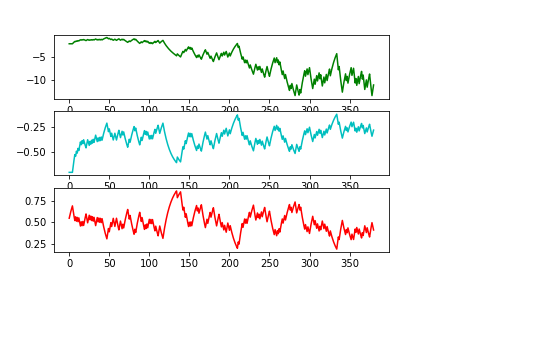

ValueError: probabilities contain NaN

In [73]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.ion()

fig.show()
fig.canvas.draw()

success_rate = []
sendr_loss = []
recvr_loss = []
success_rate_avg = 0.5
sendr_loss_avg = None
recvr_loss_avg = None
for i in range(5000):
    success = g.take_turn()
    success_rate_avg = smooth_avg(success_rate_avg, success, 0.1)
    sendr_loss_avg = smooth_avg(sendr_loss_avg, sender.last_loss, 0.1)
    recvr_loss_avg = smooth_avg(recvr_loss_avg, receiver.last_loss, 0.1)
    success_rate.append(success_rate_avg)
    sendr_loss.append(sendr_loss_avg)
    recvr_loss.append(recvr_loss_avg)
#     print(success, sender.last_loss, receiver.last_loss)
    if not i % 10:
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax1.plot(sendr_loss, "g")
        ax2.plot(recvr_loss, "c")
        ax3.plot(success_rate, "r")
        fig.canvas.draw()

In [ ]:
sender.save("sender.weights")
receiver.save("receiver.weights")


In [ ]:
sender.load("sender.weights")
receiver.load("receiver.weights")
